# Introduction 
Apple orchards in the United States are under constant threat from a large number of pathogens and insects. 
            
Appropriate and timely deployment of disease management depends on early disease detection. 

Incorrect and delayed diagnosis can result in either excessive or inadequate use of chemicals, with increased production costs and increased environmental and health impacts.

In this competition, we are challenged to diagnose plant diseases solely based on leaf images. The categories include "healthy", "scab", "rust", and "multiple diseases". 

Helping solving this problem in diagnosing plant diseases early can save tonnes of agricultural produce every year.

In this notebook i will preform EDA to better understand the dataset we have, them using Pytorch, OpenCV and more libraries to train 4 models that are Efficientnet b5 and b6, Resnet50 and Densenet 161 to create ensemble of their predicions. 


# 1. Importing and Installing 

In [1]:
!pip install efficientnet_pytorch
!pip install timm
import os
import cv2
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from transformers import get_cosine_schedule_with_warmup
from albumentations import *
from albumentations.pytorch import ToTensorV2

import torch
import timm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet

import warnings  
warnings.filterwarnings('ignore')

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0e16d4df87931f0c5af4330d81778f31d2accf6128d83d9c361a1dc176afa65d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 376 kB 2.1 MB/s eta 0:00:01


# 2. EDA

## 2.1 Visulize each category

In [20]:
# Constants
random_seed = 42
DIR_PATH = '../input/plant-pathology-2020-fgvc7'
BATCH_SIZE = 4
NUM_CLASSES = 4
LABEL_COLS = ['healthy', 'multiple_diseases', 'rust', 'scab']
SIZE = [512,512]
LR = 0.001
WEIGHT_DECAY = 0
EPOCHS = 20
WARMUP = 15
STEP_SIZE = 5 
TTA = 4

In [3]:
train = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

## 2.2 Visualization of the categories in the Dataset

Text(0.5, 1.0, 'Scab')

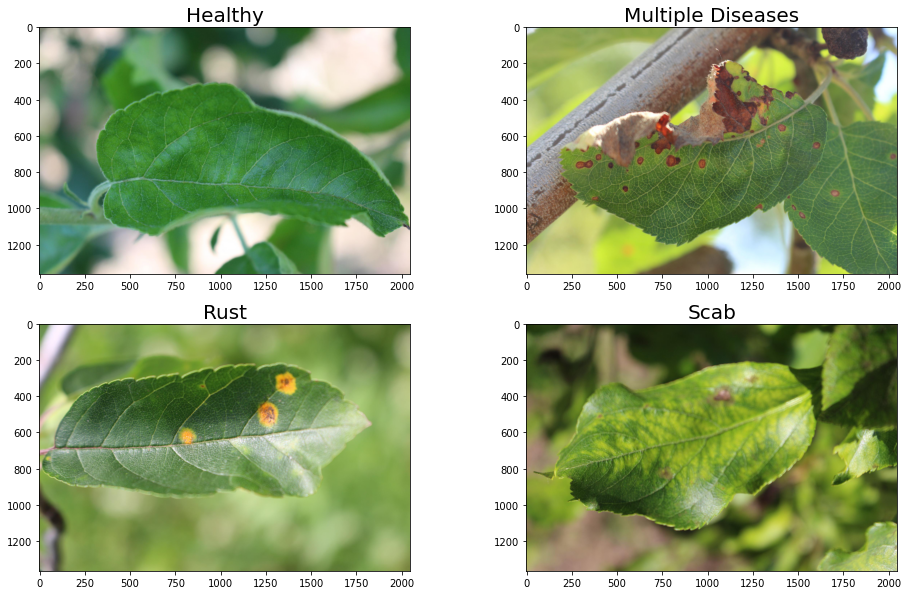

In [4]:
im_healthy = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg', format = 'jpg')

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title('Healthy', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title('Multiple Diseases', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title('Rust', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title('Scab', fontsize = 20)

## 2.3 Label Frequancy

In [5]:
fig = go.Figure([go.Pie(labels = train.columns[1:],
           values=train.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#636EFA;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
              In this Pie chart of labels, we see that there are only 28.3% of healthy leaves. approximately 2/3 of the leaves have rust or scab, and only 5% have multiple diseases.
</p>
</div>

## 2.4 Label Distribution

### 2.4.1 Healthy Distribution

In [6]:
train["Healthy"] = train["healthy"].apply(bool).apply(str)
fig = px.histogram(train, x="Healthy", title="Healthy distribution", color="Healthy",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#636EFA;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
There are more unhealthy leaves (71.6% of the data) then healthy ones (28.3% of the data).
</p>
</div> 

### 2.4.2 Scab Distribution

In [7]:
train["Scab"] = train["scab"].apply(bool).apply(str)
fig = px.histogram(train, x="Scab", color="Scab", title="Scab distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#636EFA;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
Here we see that there are more healthy leaves (without scab, which are 67.4% of the data) then leaves with scab (32.5%).
</p>
</div> 

### 2.4.3 Rust Distribution

In [8]:
train["Rust"] = train["rust"].apply(bool).apply(str)
fig = px.histogram(train, x="Rust", color="Rust", title="Rust distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#636EFA;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
Similar to scab there are more leaves without rust (65.8% of the data) then there are with rust (34.1%).
</p>
</div> 

### 2.4.4 Multiple diseases Distribution

In [9]:
train["Multiple diseases"] = train["multiple_diseases"].apply(bool).apply(str)
fig = px.histogram(train, x="Multiple diseases", color="Multiple diseases", title="Multiple diseases distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#636EFA;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
The smaller amount of samples, only 5% of the data is leaves with multiple diseases, and 95% of leaves without it.
</p>
</div>

# 3. Augmantation 

In [10]:
transform = {
    'train' : Compose([
        Resize(SIZE[0],SIZE[1],always_apply=True),
        RandomBrightnessContrast(brightness_limit=0.1, 
                               contrast_limit=0.1, p=0.5),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        OneOf([Emboss(p=1),
             Sharpen(p=1),
             Blur(p=1)], p=0.5),
        Normalize(p=1.0),
        ToTensorV2(p=1.0)
    ]),
    'valid': Compose([
        Resize(SIZE[0],SIZE[1],always_apply=True),
        Normalize(p=1.0),
        ToTensorV2(p=1.0)
    ])
}

# 4. Seeding

In [11]:
def seed_everything(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(random_seed)   
device = torch.device("cuda:0")

# 5. Plant Dataset Class

Credit to https://www.kaggle.com/apthagowda/plant-pathology-2020-pytorch-gpu/notebook

In [12]:
class Plant_Dataset(Dataset):
    
    def __init__(self, df, transform=None, train=True):
        self.df = df
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path = self.df.iloc[idx]['image_id']
        image = cv2.imread(DIR_PATH + f"/images/{path}.jpg")
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)['image']
        if self.train==True:
            label = np.argmax(self.df[LABEL_COLS].iloc[idx].values).reshape(1,1)
            return {'image': image,'label': label }
        if self.train==False:
            return {'image':image }

# 6. Datasets and Data loaders

In [13]:
train, valid = train_test_split(train, test_size = 0.2, random_state = random_seed)

dataset_train = Plant_Dataset(df=train, transform=transform['train'])
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, drop_last=True)

dataset_valid = Plant_Dataset(df=valid, transform=transform['valid'])
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=4, shuffle=False, drop_last=True)

dataset_test = Plant_Dataset(test, transform=transform['valid'], train=False)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# 7. Plotting the transforms

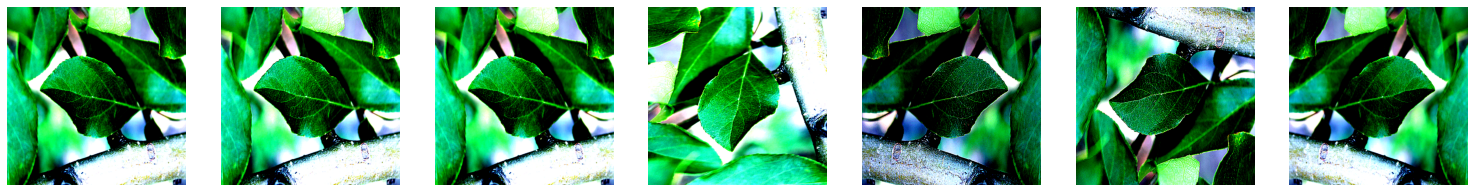

In [14]:
def plot_transform(image_id, num_images = 7):
    plt.figure(figsize = (30,10))
    plt.tight_layout()
    for i in range(1, num_images + 1):
        plt.subplot(1, num_images + 1, i)
        plt.axis('off')
        x = dataset_train.__getitem__(image_id)
        image = x['image'].numpy()
        image = np.transpose(image, [1 ,2 ,0])
        plt.imshow(image)
        
plot_transform(1)

# 8. Training Function

In [21]:
results = pd.DataFrame(columns=['training_loss', 'training_accuracy', 'validation_loss', 'validation_accuracy', 'precision', 'recall']) 
def train(model, criterion, optimizer, scheduler, dataloader_train, dataloader_valid):
    global results
    for epoch in range(EPOCHS):
        print('Epoch {}/{}'.format(epoch, EPOCHS - 1))
        since = time.time()
        model.train()
        training_accuracy  = []
        training_loss = []
        for bi, d in enumerate(tqdm(dataloader_train, total = int(len(dataloader_train)))):
            inputs = d["image"]
            labels = d["label"]
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                labels = labels.squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                outputs = torch.max(outputs, 1)[1]
                outputs = outputs.cpu().detach().numpy()
                labels = labels.cpu().numpy()
                training_accuracy.append(accuracy_score(outputs,labels))
                training_loss.append(loss.item())
        print('Training accuracy: {:.4f} and Training Loss: {:.4f}'.format(np.mean(training_accuracy), np.mean(training_loss)))

        
        #Validation                             
        model.eval()
        validation_loss = []
        validation_labels = []
        validation_outputs = []
        with torch.no_grad():
            for bi,d in enumerate(tqdm(dataloader_valid, total = int(len(dataloader_valid)))):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype = torch.float)
                labels = labels.to(device, dtype = torch.long)
                outputs = model(inputs)
                labels = labels.squeeze()
                loss = criterion(outputs,labels)
                outputs_softmax = F.softmax(outputs).cpu().detach().numpy()
                labels_onehot = torch.eye(4)[labels].cpu().numpy()
                validation_labels.extend(labels_onehot)
                validation_outputs.extend(outputs_softmax)
                validation_loss.append(loss.item())
                
        precision = precision_score(np.argmax(validation_labels, axis = 1),np.argmax(validation_outputs, axis = 1), average = 'macro')
        recall = recall_score(np.argmax(validation_labels, axis = 1),np.argmax(validation_outputs, axis = 1), average = 'macro')
        accuracy = accuracy_score(np.argmax(validation_labels, axis = 1),np.argmax(validation_outputs, axis = 1))
        print('Validation accuracy: {:.4f} and Validation Loss: {:.4f}'.format(accuracy, \
                            np.mean(validation_loss)))
        res = pd.DataFrame([[np.mean(training_loss), np.mean(training_accuracy), np.mean(validation_loss), \
                             accuracy, precision, recall]], columns = results.columns)
        results = pd.concat([results, res])
        scheduler.step()
        
    return results.iloc[-1]

# 9. Training plots function

In [16]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10 == 1: # set up the subplots on the first call
        plt.subplots(figsize = (15,15), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# 10. Custom models function

In [17]:
def get_EfficNet(model_name):
    model = EfficientNet.from_pretrained(model_name, num_classes = NUM_CLASSES)
    model = model.to(device)
    return model

# 11. Efficient Net B7 training and submitting results

Efficientnet models family powered by model scaling method, proposed by Google in this article [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946), that uses a simple yet highly effective compound coefficient to scale up CNNs in a more structured manner. Unlike conventional approaches that arbitrarily scale network dimensions, such as width, depth and resolution, the method uniformly scales each dimension with a fixed set of scaling coefficients. 

Scaling individual dimensions improves model performance, however balancing all dimensions of the network—width, depth, and image resolution—against the available resources would best improve overall performance. they preform grid-search that determines the appropriate scaling coefficient for each of the dimensions , and apply them.

This compound scaling method consistently improves model accuracy and efficiency for scaling up existing models such as MobileNet and Resnet, compared to conventional scaling methods.

![](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png)

They design a new architecture that is simmilar to MobileNet V2 by the mobile inverted bottleneck convolution, and scaled this architecture into the Efficientnet family.

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)

First it have the input Stem that contains 7 blocks, after that the number of sub-block varying between each Efficientnet version. this Stem and final layer are the same between all of them: 

![](https://miro.medium.com/max/2000/1*93Ahac6GAA04fnpVPcKZBg.png)

The Efiicientnet B7 architecture: 

![](https://miro.medium.com/max/2000/1*9LkWH_LUPi5QD1k-QcUA2g.png)

And the modules used in this image are: 

![](https://miro.medium.com/max/2000/1*cwMpOJNhwOeosjwW-usYvA.png)

### 11.1 Loading model

In [22]:
model_name = 'efficientnet-b7'
c = get_EfficNet(model_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnetb7.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
'''
Lr schedule with a learning rate that decreases following the values of the cosine function between the
initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
initial lr set in the optimizer.
'''
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = WARMUP, num_training_steps = EPOCHS) 

Loaded pretrained weights for efficientnet-b7


### 11.2 Training

In [23]:
train(effnetb7, criterion, optimizer, scheduler, dataloader_train, dataloader_valid)

Epoch 0/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.2871 and Training Loss: 1.3805


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.2885 and Validation Loss: 1.3840
Epoch 1/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.7617 and Training Loss: 0.7011


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9038 and Validation Loss: 0.3415
Epoch 2/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8750 and Training Loss: 0.4156


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9451 and Validation Loss: 0.2449
Epoch 3/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8997 and Training Loss: 0.3468


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9341 and Validation Loss: 0.2750
Epoch 4/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9107 and Training Loss: 0.3044


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9203 and Validation Loss: 0.2339
Epoch 5/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9196 and Training Loss: 0.2736


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9396 and Validation Loss: 0.1923
Epoch 6/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9121 and Training Loss: 0.2884


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9038 and Validation Loss: 0.2678
Epoch 7/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9224 and Training Loss: 0.2490


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9286 and Validation Loss: 0.2698
Epoch 8/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9080 and Training Loss: 0.2945


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9176 and Validation Loss: 0.2559
Epoch 9/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9203 and Training Loss: 0.2736


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8846 and Validation Loss: 0.4348
Epoch 10/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9196 and Training Loss: 0.2768


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8819 and Validation Loss: 0.4948
Epoch 11/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9052 and Training Loss: 0.3255


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.7692 and Validation Loss: 0.8167
Epoch 12/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9231 and Training Loss: 0.2616


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.5742 and Validation Loss: 1.6456
Epoch 13/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9114 and Training Loss: 0.2885


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9286 and Validation Loss: 0.2539
Epoch 14/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9306 and Training Loss: 0.2477


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.6429 and Validation Loss: 3.5596
Epoch 15/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9018 and Training Loss: 0.3171


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8874 and Validation Loss: 0.3444
Epoch 16/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9327 and Training Loss: 0.2417


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8736 and Validation Loss: 0.4716
Epoch 17/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9423 and Training Loss: 0.1895


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9368 and Validation Loss: 0.2452
Epoch 18/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9554 and Training Loss: 0.1515


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9148 and Validation Loss: 0.2737
Epoch 19/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9698 and Training Loss: 0.0978


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9396 and Validation Loss: 0.1868


training_loss          0.097766
training_accuracy      0.969780
validation_loss        0.186828
validation_accuracy    0.939560
precision              0.855591
recall                 0.884623
Name: 0, dtype: float64

In [24]:
torch.save(effnetb7, 'effnetb7.pth')

### 11.3 Displaying  training curves

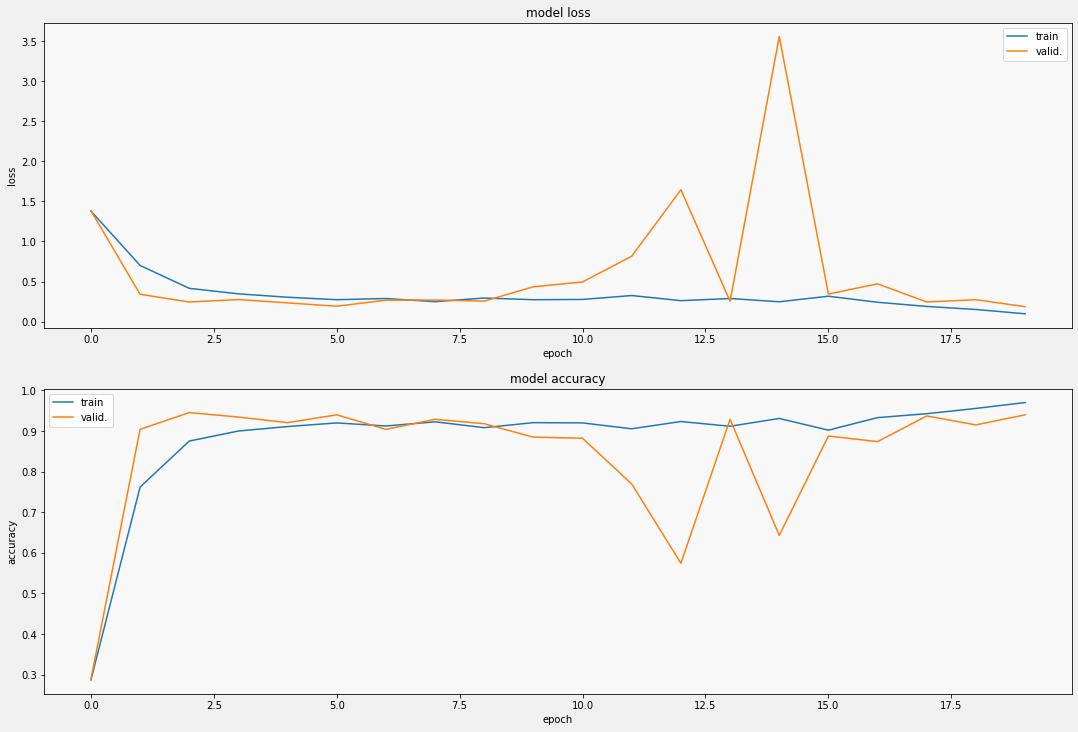

In [25]:
results.reset_index(drop = True, inplace = True)
display_training_curves(results['training_loss'], results['validation_loss'], 'loss', 311)
display_training_curves(results['training_accuracy'], results['validation_accuracy'], 'accuracy', 312)

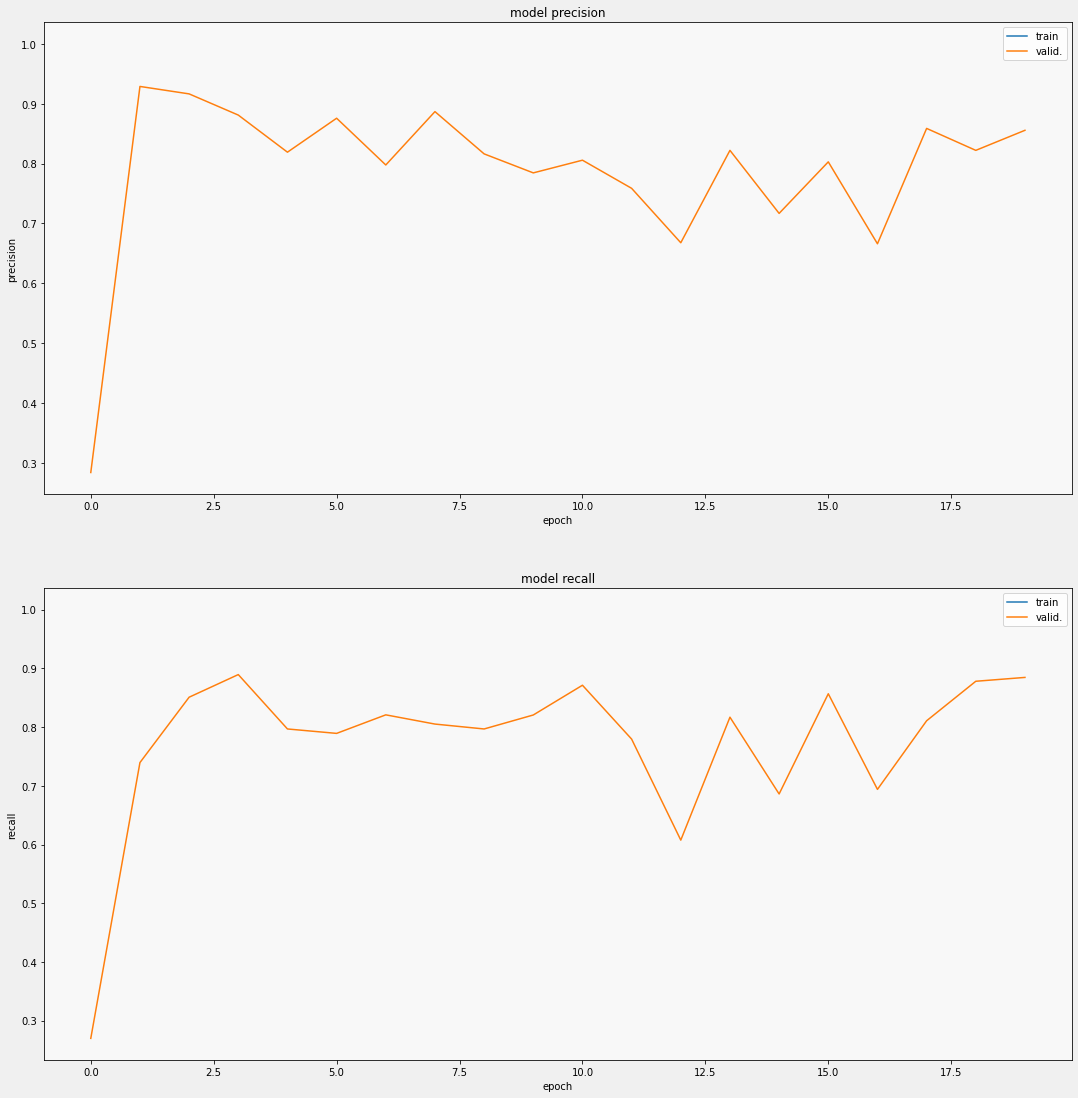

In [26]:
display_training_curves(1, results['precision'], 'precision', 211)
display_training_curves(1, results['recall'], 'recall', 212)

### 11.4 Predicting on test 

In [27]:
effnetb7 = torch.load('effnetb7.pth')
effnetb7.eval()
test_pred = np.zeros((len(test), 4))
with torch.no_grad():
    for i, data in enumerate(tqdm(dataloader_test, total = int(len(dataloader_test)))):
        inputs = data['image']
        inputs = inputs.to(device, dtype = torch.float)
        predict = effnetb7(inputs)
        test_pred[i*len(predict):(i+1)*len(predict)] = predict.detach().cpu().squeeze().numpy()

  0%|          | 0/456 [00:00<?, ?it/s]

In [28]:
submission_df = pd.read_csv(DIR_PATH + '/sample_submission.csv')
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = F.softmax(torch.from_numpy(test_pred) ,dim = 1)
submission_df.to_csv('effnetb7_submission.csv', index = False)
pd.Series(np.argmax(submission_df[LABEL_COLS].values, axis = 1)).value_counts()

2    658
3    562
0    364
1    237
dtype: int64

# 12. ResNext 101 training and submitting results

The framework that ResNets presented made it possible to train ultra deep neural networks.
The ResNext stends for next generation, the reaserches proposed cardinality (the size of the set of transformations) which is a concrete, measurable dimension that is of central importance, in addition to the dimensions of width and depth. Experiments demonstrate that increasing cardinality is a more effective way of gaining accuracy than going deeper or wider, especially when depth and
width starts to give diminishing returns for existing models. 

Resnet block and ResNext block side by side:

![](https://miro.medium.com/max/1125/1*mdiQTfovOXKnqzfj727b9Q.png)

* It follows a split-transform-aggregate strategy.
* The number of paths inside the ResNeXt block is defined as cardinality. In the above diagram C=32
* All the paths contain the same topology.
* Instead of having high depth and width, Having high cardinality helps in decreasing validation error.
* ResNeXt tries embed more subspaces compared to its ResNet counter part.
* Both the architectures have different width. Layer-1 in ResNet has one conv layer with 64 width, while layer-1 in ResNext has 32 different conv layers with 4 width (32*4 width). Despite the larger overall width in ResNeXt, both the architectures have the same number of parameters(~70k) (ResNet 256*64+3*3*64*64+64*26) (ResNeXt C*(256*d+3*3*d*d+d*256), with C=32 and d=4).


The models architectures differnces:

![](https://miro.medium.com/max/817/1*K03QPmjwWQgjNusXRK4Myw.png)

So a resnext_32x4d represents network with 4 bottleneck (one block in the above diagram) layers, and each layer having cardinality of 32. later we will observe resnext_32*4d and resnext_64*4d implementations in pytorch.

Studies in increasing cardinality while decreasing width: 

![](https://miro.medium.com/max/716/1*VmsRr6jis0Sg7asAfAT1LQ.png)

with cardinality increasing from 1 to 32, we can clearly see a descrease in top-1 % error rate. Therefore, Increasing the cardinality by decreasing the width has improved the performance of the model.

### 12.1 Clearing gpu memory

In [29]:
torch.cuda.empty_cache()
del(effnetb7)

### 12.2 Loading model

In [51]:
resnext = timm.create_model('resnext101_32x8d', pretrained=True, num_classes = 4)
resnext = resnext.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnext.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = WARMUP, num_training_steps = EPOCHS)

### 12.3 Training

In [33]:
train(resnext, criterion, optimizer, scheduler, dataloader_train, dataloader_valid)

Epoch 0/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.1992 and Training Loss: 1.4178


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.2253 and Validation Loss: 1.4123
Epoch 1/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.7885 and Training Loss: 0.6047


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9451 and Validation Loss: 0.2508
Epoch 2/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8413 and Training Loss: 0.5141


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9011 and Validation Loss: 0.3341
Epoch 3/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8503 and Training Loss: 0.4821


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9231 and Validation Loss: 0.2916
Epoch 4/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8482 and Training Loss: 0.4939


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8956 and Validation Loss: 0.3591
Epoch 5/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8647 and Training Loss: 0.4835


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9148 and Validation Loss: 0.3023
Epoch 6/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8633 and Training Loss: 0.4580


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8764 and Validation Loss: 0.4084
Epoch 7/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8455 and Training Loss: 0.5109


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9121 and Validation Loss: 0.3165
Epoch 8/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8757 and Training Loss: 0.4234


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9231 and Validation Loss: 0.2876
Epoch 9/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8372 and Training Loss: 0.5465


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8764 and Validation Loss: 0.3677
Epoch 10/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8537 and Training Loss: 0.4690


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9121 and Validation Loss: 0.3063
Epoch 11/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8565 and Training Loss: 0.4549


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9203 and Validation Loss: 0.3135
Epoch 12/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8819 and Training Loss: 0.3954


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9066 and Validation Loss: 0.3266
Epoch 13/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8654 and Training Loss: 0.4648


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8269 and Validation Loss: 0.4629
Epoch 14/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8791 and Training Loss: 0.4095


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.7335 and Validation Loss: 0.5932
Epoch 15/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8750 and Training Loss: 0.4120


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8352 and Validation Loss: 0.5199
Epoch 16/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8791 and Training Loss: 0.3994


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8544 and Validation Loss: 0.4355
Epoch 17/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9045 and Training Loss: 0.3110


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8956 and Validation Loss: 0.3800
Epoch 18/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9258 and Training Loss: 0.2722


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9231 and Validation Loss: 0.2377
Epoch 19/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9437 and Training Loss: 0.2018


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9286 and Validation Loss: 0.2544


training_loss          0.201786
training_accuracy      0.943681
validation_loss        0.254450
validation_accuracy    0.928571
precision              0.905500
recall                 0.793353
Name: 0, dtype: float64

In [34]:
torch.save(resnext, 'resnext.pth')

### 12.4 Displaying  training curves

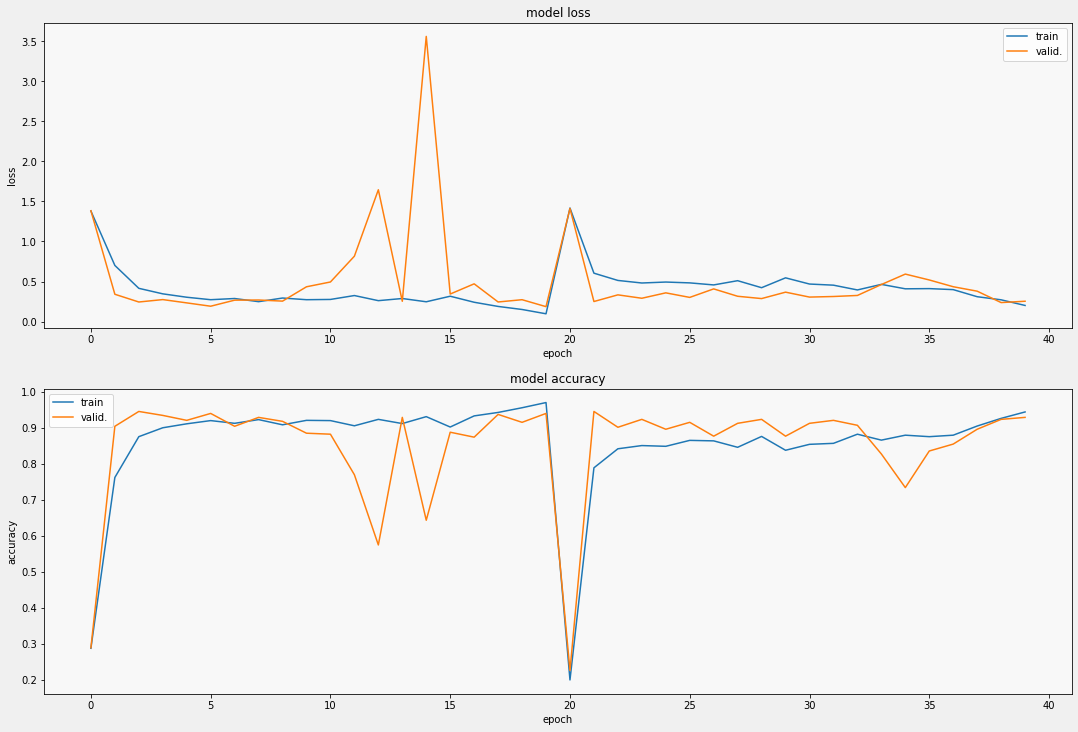

In [35]:
results.reset_index(drop=True,inplace=True)
display_training_curves(results['training_loss'], results['validation_loss'], 'loss', 311)
display_training_curves(results['training_accuracy'], results['validation_accuracy'], 'accuracy', 312)

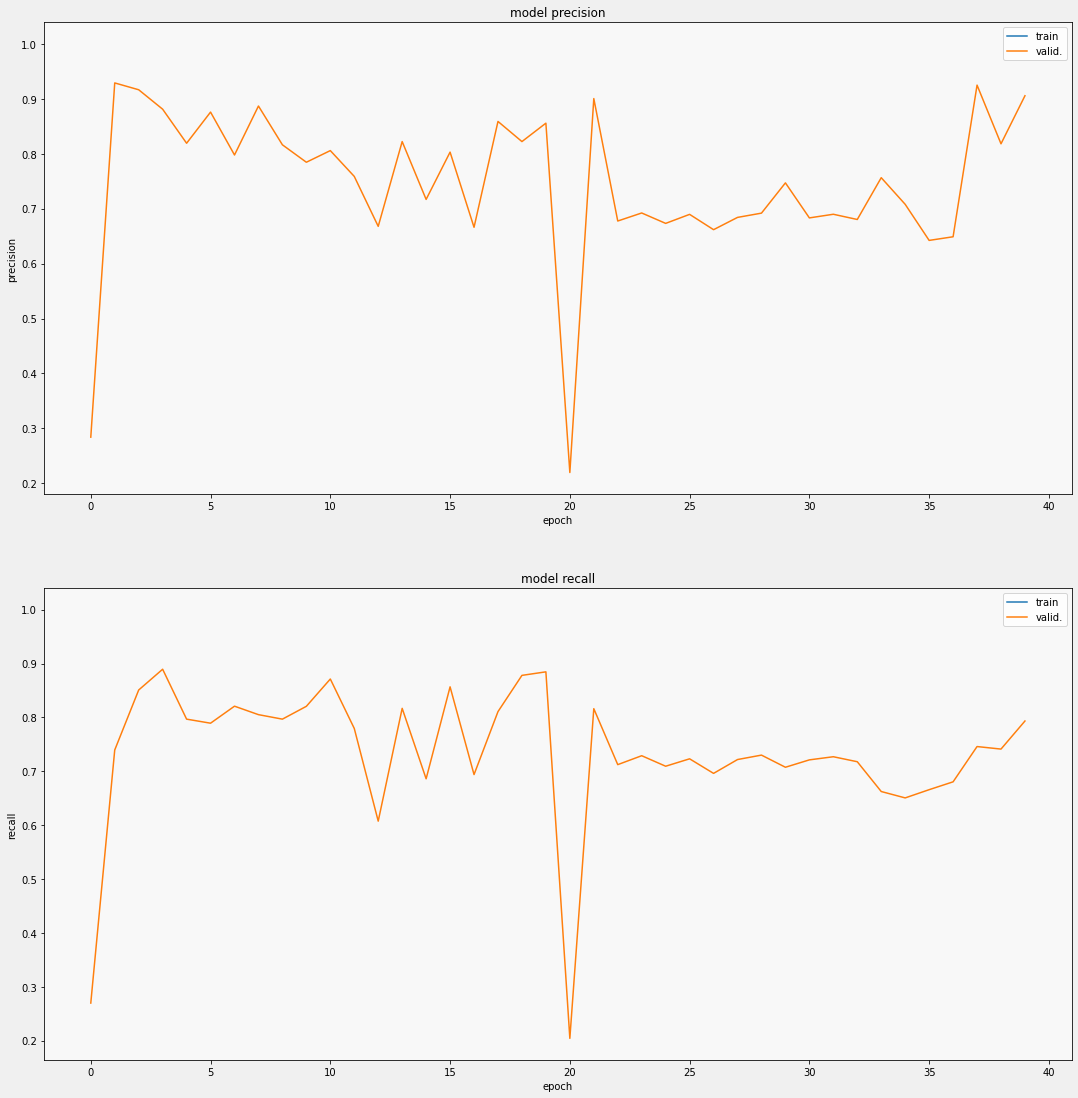

In [36]:
display_training_curves(1, results['precision'], 'precision', 211)
display_training_curves(1, results['recall'], 'recall', 212)

### 12.5 Predicting on test 

In [37]:
resnext = torch.load('resnext.pth')
resnext.eval()
test_pred = np.zeros((len(test), 4))
with torch.no_grad():
    for i, data in enumerate(tqdm(dataloader_test, total = int(len(dataloader_test)))):
        inputs = data['image']
        inputs = inputs.to(device, dtype = torch.float)
        predict = resnext(inputs)
        test_pred[i*len(predict):(i+1)*len(predict)] = predict.detach().cpu().squeeze().numpy()

  0%|          | 0/456 [00:00<?, ?it/s]

In [38]:
submission_df = pd.read_csv(DIR_PATH + '/sample_submission.csv')
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = F.softmax(torch.from_numpy(test_pred), dim = 1)
submission_df.to_csv('resnext_submission.csv', index = False)
pd.Series(np.argmax(submission_df[LABEL_COLS].values, axis = 1)).value_counts()

2    706
3    584
0    446
1     85
dtype: int64

# 13. Efficientnet B6 training and submitting results

More thorough information about the Efficientnet family is explained in section 11, and we will just dive in to B6 architecture:

The first and final layers:

![](https://miro.medium.com/max/2000/1*93Ahac6GAA04fnpVPcKZBg.png)

The architecture:

![](https://miro.medium.com/max/2000/1*2OXrqNg_7CMuNFg2T6eRUA.png)

And the modules are:

![](https://miro.medium.com/max/2000/1*cwMpOJNhwOeosjwW-usYvA.png)

### 13.1 Clearing gpu memory

In [39]:
torch.cuda.empty_cache()
del(resnext)

### 13.2 Loading custom model

In [40]:
model_name = 'efficientnet-b6'
effnetB6 = get_EfficNet(model_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnetB6.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = WARMUP, num_training_steps = EPOCHS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


### 13.3 Training

In [41]:
train(effnetB6, criterion, optimizer,scheduler, dataloader_train, dataloader_valid)

Epoch 0/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.2871 and Training Loss: 1.3820


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.3132 and Validation Loss: 1.3794
Epoch 1/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.7637 and Training Loss: 0.7132


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9341 and Validation Loss: 0.2425
Epoch 2/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8592 and Training Loss: 0.4336


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9451 and Validation Loss: 0.1919
Epoch 3/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9032 and Training Loss: 0.3358


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9093 and Validation Loss: 0.2825
Epoch 4/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9038 and Training Loss: 0.2872


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9011 and Validation Loss: 0.2658
Epoch 5/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9231 and Training Loss: 0.2842


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8819 and Validation Loss: 0.5059
Epoch 6/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9169 and Training Loss: 0.2659


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9451 and Validation Loss: 0.1888
Epoch 7/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9100 and Training Loss: 0.2618


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8956 and Validation Loss: 0.3118
Epoch 8/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9258 and Training Loss: 0.2501


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9176 and Validation Loss: 0.3962
Epoch 9/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9169 and Training Loss: 0.2756


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9341 and Validation Loss: 0.1971
Epoch 10/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9162 and Training Loss: 0.2356


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9396 and Validation Loss: 0.2126
Epoch 11/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9045 and Training Loss: 0.2960


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8571 and Validation Loss: 0.5386
Epoch 12/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9258 and Training Loss: 0.2483


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9286 and Validation Loss: 0.2972
Epoch 13/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9176 and Training Loss: 0.2669


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9011 and Validation Loss: 0.3951
Epoch 14/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9279 and Training Loss: 0.2523


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9478 and Validation Loss: 0.1741
Epoch 15/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9210 and Training Loss: 0.2658


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8791 and Validation Loss: 0.4581
Epoch 16/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9286 and Training Loss: 0.2238


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.7418 and Validation Loss: 1.0085
Epoch 17/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9437 and Training Loss: 0.1839


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9368 and Validation Loss: 0.2132
Epoch 18/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9684 and Training Loss: 0.0970


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9176 and Validation Loss: 0.3286
Epoch 19/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.9787 and Training Loss: 0.0689


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9533 and Validation Loss: 0.1813


training_loss          0.068932
training_accuracy      0.978709
validation_loss        0.181263
validation_accuracy    0.953297
precision              0.887645
recall                 0.940635
Name: 0, dtype: float64

In [42]:
torch.save(effnetB6, 'effnetB6.pth')

### 13.4 Displaying  training curves

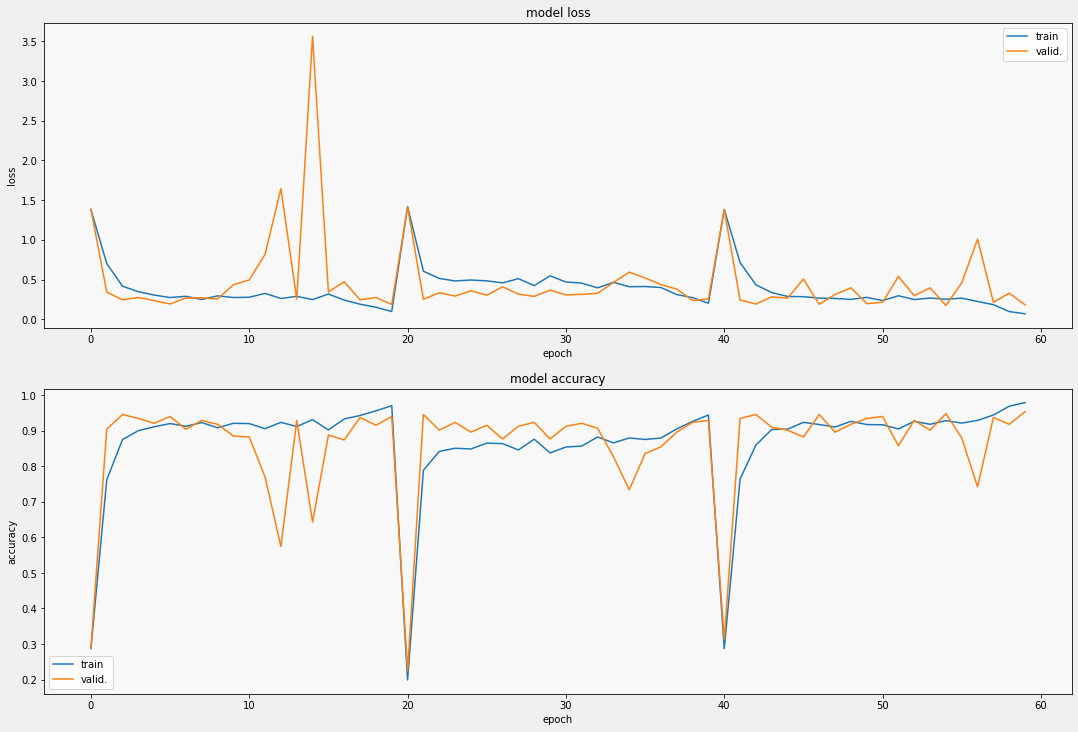

In [43]:
results.reset_index(drop=True,inplace=True)
display_training_curves(results['training_loss'], results['validation_loss'], 'loss', 311)
display_training_curves(results['training_accuracy'], results['validation_accuracy'], 'accuracy', 312)

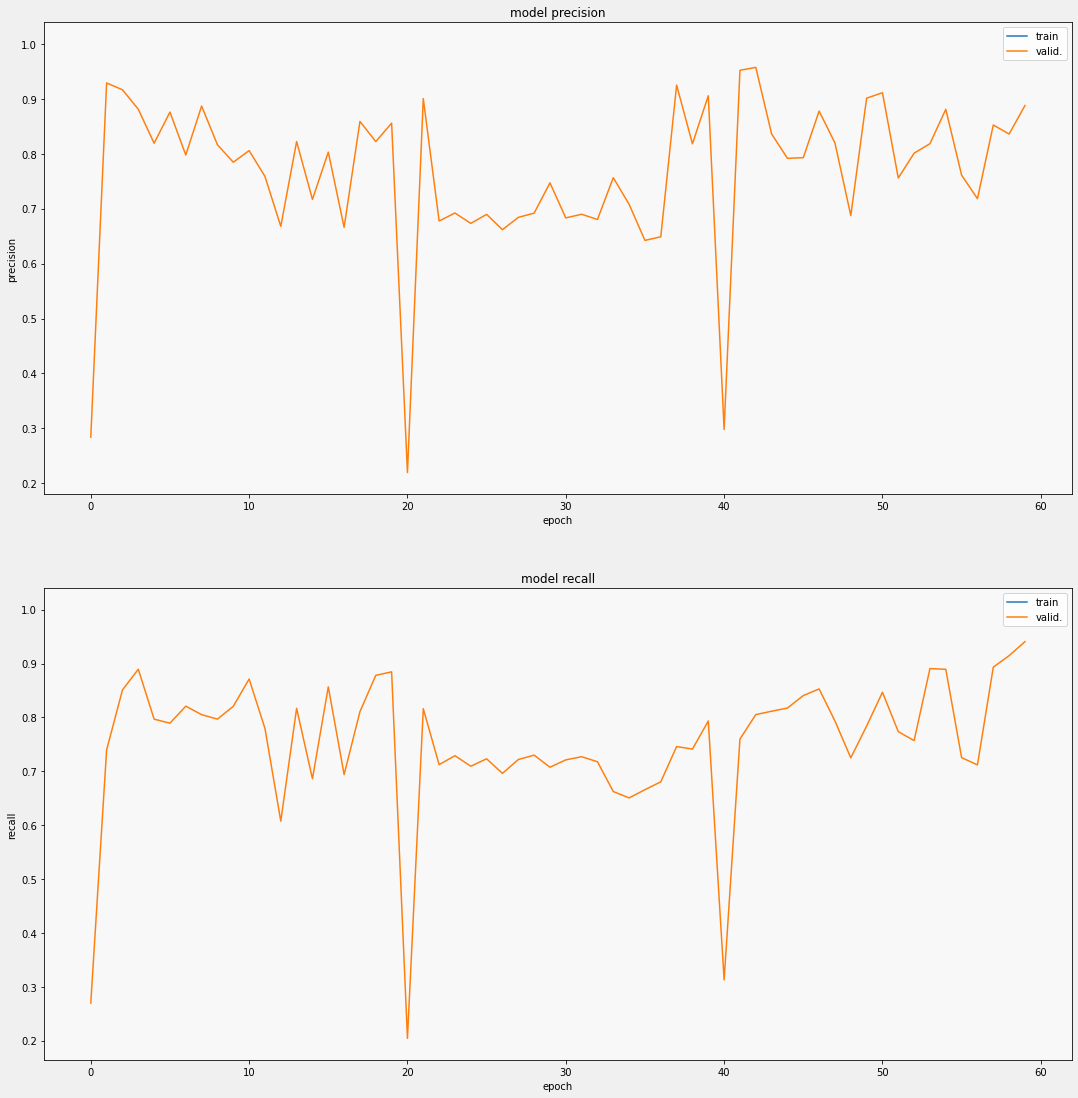

In [44]:
display_training_curves(1, results['precision'], 'precision', 211)
display_training_curves(1, results['recall'], 'recall', 212)

### 13.5 Predicting on test 

In [45]:
effnetB6 = torch.load('effnetB6.pth')
effnetB6.eval()
test_pred = np.zeros((len(test), 4))
with torch.no_grad():
    for i, data in enumerate(tqdm(dataloader_test, total = int(len(dataloader_test)))):
        inputs = data['image']
        inputs = inputs.to(device, dtype = torch.float)
        predict = effnetB6(inputs)
        test_pred[i*len(predict):(i+1)*len(predict)] = predict.detach().cpu().squeeze().numpy()

  0%|          | 0/456 [00:00<?, ?it/s]

In [46]:
submission_df = pd.read_csv(DIR_PATH + '/sample_submission.csv')
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = F.softmax(torch.from_numpy(test_pred), dim = 1)
submission_df.to_csv('effnetB6_submission.csv', index = False)
pd.Series(np.argmax(submission_df[LABEL_COLS].values, axis = 1)).value_counts()

2    616
3    589
0    367
1    249
dtype: int64

# 14. Dense net 161 training and submitting results

Densely Connected Convolutional Networks (DenseNets), are a popular CNN-based ImageNet used for a variety of applications, inclusing classification, segmentation, localization, etc.
Most models before DenseNet relied solely on network depth for representational power. 
Instead of drawing representational power from extremely deep or wide architectures, DenseNets exploit the potential of the network through feature reuse.

Densenet connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters. connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections - one between each layer and its subsequent layer - our network has L(L+1)/2 direct connections. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several compelling advantages: they alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters. 

![DenseNet](https://i.imgur.com/wWHWbQt.jpghttps://i.imgur.com/wWHWbQt.jpg)

![](https://www.researchgate.net/publication/341582569/figure/tbl2/AS:894154146074646@1590194369858/DenseNet-161-architecture-used-in-our-study.png)

### 14.1 Clearing gpu memory

In [47]:
torch.cuda.empty_cache()
del(effnetB6)

### 14.2 Loading model

In [48]:
densenet = timm.create_model('densenet161', pretrained=True, num_classes = 4)
densenet = densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = WARMUP, num_training_steps = EPOCHS)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


### 14.3 Training

In [ ]:
train(densenet, criterion, optimizer, scheduler, dataloader_train, dataloader_valid)

Epoch 0/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.2857 and Training Loss: 1.3920


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.2747 and Validation Loss: 1.4042
Epoch 1/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.7960 and Training Loss: 0.5953


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9341 and Validation Loss: 0.2319
Epoch 2/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8503 and Training Loss: 0.4710


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9478 and Validation Loss: 0.2089
Epoch 3/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8468 and Training Loss: 0.4908


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.8984 and Validation Loss: 0.3060
Epoch 4/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8757 and Training Loss: 0.4203


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9368 and Validation Loss: 0.2373
Epoch 5/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8716 and Training Loss: 0.4248


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9121 and Validation Loss: 0.3099
Epoch 6/19


  0%|          | 0/364 [00:00<?, ?it/s]

Training accuracy: 0.8578 and Training Loss: 0.4416


  0%|          | 0/91 [00:00<?, ?it/s]

Validation accuracy: 0.9231 and Validation Loss: 0.3659
Epoch 7/19


  0%|          | 0/364 [00:00<?, ?it/s]

In [ ]:
torch.save(densenet, 'densenet.pth')

### 14.4 Displaying  training curves

In [ ]:
results.reset_index(drop=True,inplace=True)
display_training_curves(results['training_loss'], results['validation_loss'], 'loss', 311)
display_training_curves(results['training_accuracy'], results['validation_accuracy'], 'accuracy', 312)

In [ ]:
display_training_curves(1, results['precision'], 'precision', 211)
display_training_curves(1, results['recall'], 'recall', 212)

### 14.5 Predicting on test 

In [ ]:
densenet = torch.load('densenet.pth')
densenet.eval()
test_pred = np.zeros((len(test), 4))
with torch.no_grad():
    for i, data in enumerate(tqdm(dataloader_test, total = int(len(dataloader_test)))):
        inputs = data['image']
        inputs = inputs.to(device, dtype = torch.float)
        predict = densenet(inputs)
        test_pred[i*len(predict):(i+1)*len(predict)] = predict.detach().cpu().squeeze().numpy()

In [ ]:
submission_df = pd.read_csv(DIR_PATH + '/sample_submission.csv')
submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = F.softmax(torch.from_numpy(test_pred), dim = 1)
submission_df.to_csv('densenet_submission.csv', index = False)
pd.Series(np.argmax(submission_df[LABEL_COLS].values, axis = 1)).value_counts()

# 15. Ensemble

In [ ]:
sub = pd.read_csv("../input/plant-pathology-2020-fgvc7/sample_submission.csv")
sub1 = pd.read_csv("./effnetb7_submission.csv")
sub2 = pd.read_csv("./resnext_submission.csv")
sub3 = pd.read_csv("./effnetB6_submission.csv")
sub4 = pd.read_csv("./densenet_submission.csv")

sub.healthy = ( sub1.healthy + sub2.healthy + sub3.healthy + sub4.healthy)/4
sub.multiple_diseases = (sub1.multiple_diseases + sub2.multiple_diseases + sub3.multiple_diseases + sub4.multiple_diseases)/4
sub.rust = (sub1.rust + sub2.rust + sub3.rust + sub4.rust)/4
sub.scab = (sub1.scab + sub2.scab + sub3.scab + sub4.scab)/4

sub.to_csv('submission.csv', index=False)